In [3]:
# Loading libraries, initializing random numbers, setting constants
import os
from tqdm.autonotebook import tqdm, trange
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time

from sklearn.model_selection import train_test_split
from pathlib import Path
from torch.utils.data import DataLoader

from torch.utils.data import Dataset
from sklearn.preprocessing import LabelEncoder
import pickle
from PIL import Image

In [4]:
import random 
SEED = 7

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [5]:
TRAIN_DIR = Path('../input/journey-springfield/train')
TEST_DIR = Path('../input/journey-springfield/testset')

DATA_MODES = ['train', 'val', 'test']
RESCALE_SIZE = 224
DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'
CUDA_LAUNCH_BLOCKING=1
BATCH_SIZE=128

print(DEVICE)

cuda:0


In [6]:
# Creating a class for the dataset. Added augmentation to it for the 'train' mode.
class SimpsonsDataset(Dataset):

    def __init__(self, files, mode):
        super().__init__()
        self.files = sorted(files)
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ])
        data_transforms = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomAutocontrast(p=0.5),])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        if self.mode == 'train':
          x = data_transforms(x)
        else:
          x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
        
    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [7]:
# Loading data. Data balancing was carried out (the code was stolen from the comments to the task). In classes where the number of pictures is 
# less than 100, the pictures are simply duplicated to 100. At the same time, augmentation should help with retraining.
train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

In [8]:
n_classes = len(np.unique(train_val_labels))
n_classes

42

In [9]:
train_labels = [path.parent.name for path in train_files] 
val_labels = [path.parent.name for path in val_files]     

In [10]:
def create_dct_path_labels(train_files, train_labels):
    dct_simpsons = {}
    for label_i in np.unique(train_labels).tolist():
        dct_simpsons[label_i] = []

    for path_i, label_i in zip(train_files, train_labels):
        dct_simpsons[label_i].append(path_i)

    return dct_simpsons

def print_dct(dct_simpsons):
    for key in dct_simpsons:
        print(f"{key}\t{dct_simpsons[key]}")

In [11]:
dct_path_train = create_dct_path_labels(train_files, train_labels)

In [12]:
# Let's add pictures of classes that have less than 100 pictures, up to 100 pictures in the class
for person in dct_path_train:
    if len(dct_path_train[person]) < 100:
        dct_path_train[person] = dct_path_train[person] * (100 // len(dct_path_train[person]))
        dct_path_train[person].extend(dct_path_train[person][:100 - len(dct_path_train[person])])

# Let's check what happened
for person in dct_path_train:
    print(f"{person}\t{len(dct_path_train[person])}")

abraham_grampa_simpson	685
agnes_skinner	100
apu_nahasapeemapetilon	467
barney_gumble	100
bart_simpson	1006
carl_carlson	100
charles_montgomery_burns	895
chief_wiggum	739
cletus_spuckler	100
comic_book_guy	352
disco_stu	100
edna_krabappel	343
fat_tony	100
gil	100
groundskeeper_willie	100
homer_simpson	1684
kent_brockman	373
krusty_the_clown	904
lenny_leonard	233
lionel_hutz	100
lisa_simpson	1015
maggie_simpson	100
marge_simpson	968
martin_prince	100
mayor_quimby	185
milhouse_van_houten	809
miss_hoover	100
moe_szyslak	1089
ned_flanders	1090
nelson_muntz	269
otto_mann	100
patty_bouvier	100
principal_skinner	895
professor_john_frink	100
rainier_wolfcastle	100
ralph_wiggum	100
selma_bouvier	100
sideshow_bob	658
sideshow_mel	100
snake_jailbird	100
troy_mcclure	100
waylon_smithers	136


In [13]:
def create_dct_from_labels(train_val_labels):

    dct_simpsons = {}
    for label_i in np.unique(train_val_labels).tolist():
        dct_simpsons.update({label_i:train_val_labels.count(label_i)})

    return dct_simpsons

new_train_files = []

for person in dct_path_train:
    new_train_files.extend(dct_path_train[person])

new_train_label = [path.parent.name for path in new_train_files]

In [14]:
val_dataset = SimpsonsDataset(val_files, mode='val')
new_train_dataset = SimpsonsDataset(new_train_files, mode='train')

In [15]:
# Functions for training the model (left unchanged)
def fit_epoch(model, train_dataloader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_dataloader:
        inputs = inputs.to(DEVICE) 
        labels = labels.to(DEVICE)
        optimizer.zero_grad() #we reset the gradients so that they do not accumulate

        outputs = model(inputs) #we run data from the trainloader through our network (model)
        loss = criterion(outputs, labels) #counting the loss
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1) #anything greater than 1 is reduced to 1
        running_loss += loss.item() * inputs.size(0) 
        running_corrects += torch.sum(preds == labels.data) #if the prediction matches the answer, increase by 1 running_corrects
        processed_data += inputs.size(0) 
              
    train_loss = running_loss / processed_data 
    train_acc = running_corrects.cpu().numpy() / processed_data 
    return train_loss, train_acc

In [16]:
def eval_epoch(model, val_dataloader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_dataloader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [17]:
def train(train_files, val_files, model, epochs, batch_size):
    train_dataloader = DataLoader(new_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
       
        opt = torch.optim.Adam(model.parameters(), lr=3e-4)
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_dataloader, criterion, opt)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_dataloader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
    return history

In [18]:
# Transfer learning with partial freezing of layers on the Alex Net network
model = models.alexnet(pretrained=True)

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

In [19]:
layers_to_unfreeze = 5

for param in model.features[:-layers_to_unfreeze].parameters():
    param.requires_grad = False
    
num_features = 9216
model.classifier = nn.Linear(9216, n_classes)

model = model.to(DEVICE)

In [20]:
history = train(new_train_dataset, val_dataset, model=model, epochs=8, batch_size=BATCH_SIZE)

epoch:   0%|          | 0/8 [00:00<?, ?it/s]

loss 1.3780633175150816


epoch:  12%|█▎        | 1/8 [03:52<27:06, 232.30s/it]


Epoch 001 train_loss: 1.3781     val_loss 0.6192 train_acc 0.6514 val_acc 0.8391
loss 0.38071902417402786


epoch:  25%|██▌       | 2/8 [06:41<19:31, 195.31s/it]


Epoch 002 train_loss: 0.3807     val_loss 0.4338 train_acc 0.8987 val_acc 0.8892
loss 0.21242469925522697


epoch:  38%|███▊      | 3/8 [09:31<15:18, 183.69s/it]


Epoch 003 train_loss: 0.2124     val_loss 0.4089 train_acc 0.9461 val_acc 0.9014
loss 0.1330091601788345


epoch:  50%|█████     | 4/8 [12:19<11:50, 177.62s/it]


Epoch 004 train_loss: 0.1330     val_loss 0.4066 train_acc 0.9658 val_acc 0.9016
loss 0.08529404001489621


epoch:  62%|██████▎   | 5/8 [15:08<08:43, 174.43s/it]


Epoch 005 train_loss: 0.0853     val_loss 0.4401 train_acc 0.9789 val_acc 0.9064
loss 0.06372362166956248


epoch:  75%|███████▌  | 6/8 [17:57<05:44, 172.45s/it]


Epoch 006 train_loss: 0.0637     val_loss 0.4561 train_acc 0.9838 val_acc 0.9070
loss 0.047613642078535766


epoch:  88%|████████▊ | 7/8 [20:46<02:51, 171.26s/it]


Epoch 007 train_loss: 0.0476     val_loss 0.4721 train_acc 0.9886 val_acc 0.9142
loss 0.034771906556057205


epoch: 100%|██████████| 8/8 [23:35<00:00, 176.93s/it]


Epoch 008 train_loss: 0.0348     val_loss 0.4812 train_acc 0.9920 val_acc 0.9144


In [22]:
torch.save(model.state_dict(), 'Simpsons_AlexNet.pth')
model.load_state_dict(torch.load('Simpsons_AlexNet.pth'))

<All keys matched successfully>

In [23]:
loss, acc, val_loss, val_acc = zip(*history)

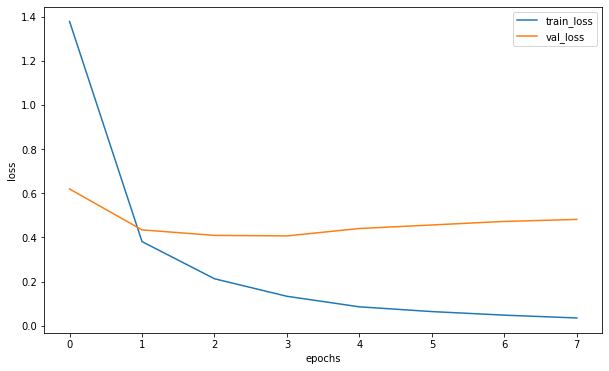

In [24]:
plt.figure(figsize=(10, 6))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

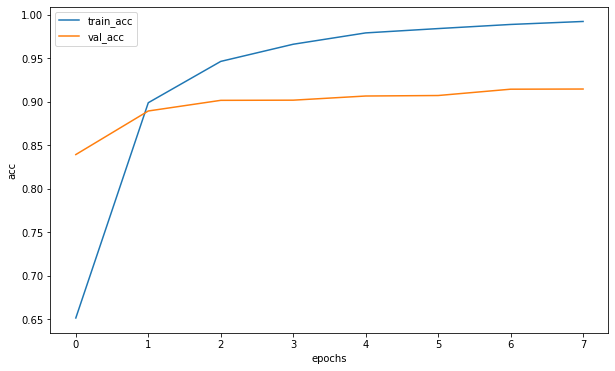

In [45]:
plt.figure(figsize=(10, 6))
plt.plot(acc, label="train_acc")
plt.plot(tuple(i.tolist() for i in val_acc), label="val_acc")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("acc")
plt.show()

In [46]:
# Getting a prediction
def predict(model, test_loader):
    with torch.no_grad(): #без градиентов
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [47]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Prediction, for one picture"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [48]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(model, ex_img.unsqueeze(0))

idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(model, imgs)

label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

In [49]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(model, test_loader) #a matrix with probabilities for each class

preds = label_encoder.inverse_transform(np.argmax(probs, axis=1)) #vector with the highest probabilities
test_filenames = [path.name for path in test_dataset.files]

In [51]:
import pandas as pd
df = pd.DataFrame()
df['Id'] = test_filenames
df['Expected'] = preds
# df.to_csv(Path('./submission_.csv'), index=False)
df.to_csv('submission.csv', index = False)

# Result's 0.96386